In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
%matplotlib inline

np.random.seed(25)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Yield_all = pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/allbond_yield.csv' , index_col=0)
#ここもしかしたらいらないかも？

Yield_all.index = pd.date_range('1980-1-1', periods=Yield_all.shape[0],freq='M')
Yield_all.columns
z = np.array(range(21)).reshape(-1)
X = Yield_all.index[240:-2]
X

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31'],
              dtype='datetime64[ns]', length=243, freq='M')

In [3]:
Yield_all.columns

Index(['FF', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y'], dtype='object')

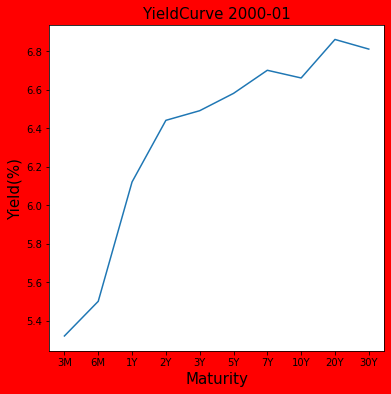

In [4]:
fig = plt.figure(figsize=(6,6),facecolor='r')
plt.plot(np.array(['3M','6M','1Y','2Y','3Y','5Y','7Y','10Y','20Y','30Y']),Yield_all.iloc[240,1:])
plt.xlabel('Maturity',fontsize=15)
plt.ylabel('Yield(%)',fontsize=15)
plt.title('YieldCurve 2000-01',fontsize=15)
plt.show()

fig.savefig('exampleYieldcurve')

In [5]:
columns = np.array(['2Y','5Y','10Y','20Y'])

### イールドカーブの主成分分析

In [6]:
Yield_all=Yield_all[240:-2].values
scaler2=StandardScaler()
Yield__std2=scaler2.fit_transform(Yield_all)
Yield__std2.shape

(243, 11)

In [7]:
pca2=PCA(n_components=3)
pca2.fit(Yield__std2)
Yield__pca2=pca2.transform(Yield__std2)

In [8]:
#主成分(列名が主成分を表す)
#Yield__pca2

#主成分を導出する際の係数（各説明変数に掛け算）
#pca2.components_

#計算の確認
#I=pca1.components_[0]@Yield__std[0].T
#I
#lはYield__pcaの[0,0]に一致しているはず

#累積寄与率の計算
np.cumsum(pca2.explained_variance_ratio_)
pca2.explained_variance_ratio_

#因子負荷率
#pca2.components_ * np.sqrt(pca2.explained_variance_)[:, np.newaxis]
#第一主成分はどれも関係ありそう(水準,傾斜(傾き),曲率)

array([0.88397458, 0.10660626, 0.00731032])

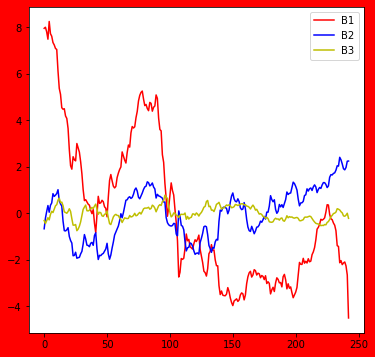

In [ ]:
#主成分=ファクターの推移
fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(Yield__pca2[:,0],color='r',label='B1')
plt.plot(Yield__pca2[:,1],color='b',label='B2')
plt.plot(Yield__pca2[:,2],color='y',label='B3')
plt.legend(loc='best')
plt.show()

fig.savefig('factor.png')

### (Statsmodelsによる)状態空間モデル

1. 時変係数（状態方程式の係数推定があり）
2. 時変係数（状態方程式の係数推定がなし(=1である））
3. 状態空間（水準・傾き・曲率も推定,design matrixは時変にしていない）

https://www.statsmodels.org/stable/statespace.html#custom-state-space-models

https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_custom_models.html?highlight=custom%20state%20space

https://qiita.com/hamage/items/f9221dd63f3001798484

https://qiita.com/kidaufo/items/bb36e11f95ebc4528e5c

In [9]:
###状態空間モデル
###説明変数として主成分3つを用いる
#主成分(列名が主成分)
B0=Yield__pca2[:,[0]]#水準
B1=Yield__pca2[:,[1]]#傾き
B2=Yield__pca2[:,[2]]#曲率

#被説明変数(2年債券,5年債券,10年債券,20年債券)
Yield_test=Yield_all[:,[4,5,7,8]]

###データセットの準備
df_train=Yield_test[:222]
df_test=Yield_test[222:]

Lt_train=B0[:222]
Lt_test=B0[222:]

St_train=B1[:222]
St_test=B1[222:]

Ct_train=B2[:222]
Ct_test=B2[222:]

df_test.shape

#B0.std(),B1.std(),B2.std()

(21, 4)

In [10]:
pd.DataFrame(Yield_test).describe()

,0,1,2,3
count,243.000000,243.000000,243.000000,243.000000
mean,2.104938,2.326379,3.108230,3.406461
std,1.704747,1.615718,1.359512,1.250227
min,0.210000,0.330000,0.780000,0.870000
25%,0.695000,0.990000,2.020000,2.310000
50%,1.620000,1.810000,2.870000,3.390000
75%,3.070000,3.420000,4.135000,4.385000
max,6.810000,6.770000,6.720000,6.660000


In [11]:
#np.random.seed(10)
#lt = ss2[:,0].mean()#Ltの係数

def make_design_matrix(step,estm_var,first_param):
    st_std = np.random.normal(0,(estm_var[0])**0.5,(step))
    ct_std = np.random.normal(0,(estm_var[1])**0.5,(step))

    li_st = list()
    li_ct = list()
    st_first = first_param[0] + st_std[0]
    ct_first = first_param[1] + st_std[0]
    li_st.append(st_first)
    li_ct.append(ct_first)

    for i in range(1,step):
      st = li_st[i-1] + st_std[i]
      ct = li_ct[i-1] + ct_std[i]
      li_st.append(st)
      li_ct.append(ct)

    st = np.array(li_st)
    ct = np.array(li_ct)

    return st,ct

#### 1.時変係数（状態方程式の係数推定あり）

In [ ]:
## 状態方程式
## 水準・傾き・曲率の係数の推定（時変係数の推定)
### 1個前の値に係数がかかり、ノイズが加わる

#########結果##########

###Ltの係数の値が右下がり・・・。本来なら1の値になるはず。
###予測の時変係数を新たにいれる必要があって予測しにくい。
###代替案としてpredict期間中のものをサンプルデータでやるか・・・

class TVRegressionrho(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, Lt, St, Ct):
        exog = np.c_[Lt, St, Ct]
        # shaped nobs x 3(マクロ経済変数を含めたら7)

        super(TVRegressionrho, self).__init__(endog=y_t, exog=exog, k_states=3,#####ここ3->23（説明変数の数）に増やす
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1

        self.ssm['design'] = exog.T[np.newaxis, :, :] # shaped 1 x 3 x nobs
        self.ssm['design',0,0,:] = 1
        self.ssm['selection'] = np.eye(self.k_states)  
        self.ssm['transition'] = np.eye(self.k_states)

       

        #Which parameters need to be positive?
        #誤差の推定なので、二乗誤差の値が負にならないようにという意味ではないだろうか？
        #self.positive_parameters = slice(0, 4)
        self.positive_parameters = slice(0, 3)
        ##self.positive_parameters = slice(0, 7)


    @property
    def param_names(self):
        
        #return ['var.e', 'var.Lt.coeff', 'var.St.coeff', 'var.Ct.coeff', 'rho0', 'rho1', 'rho2']
        return ['var.e', 'var.St.coeff', 'var.Ct.coeff', 'rho0', 'rho1', 'rho2']
        #return ['var.e', 'var.St.coeff', 'var.Ct.coeff', 'rho1', 'rho2']
        
        #####ここ23個（説明変数の数）に増やす（今はx_t, w_t, q_tの3つ）

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        #params = np.r_[res.params[0], res.scale, 1, 0.001, 0.0001, 0.1, 0.1, 0.1]
        #params = np.r_[res.scale, 0, 10, 10, 1, 1.2, 1.2]
        params = np.r_[res.scale, 10, 20, 1., 1.2, 1.2]
        #params = np.r_[res.scale, 20, 20, 1.2, 1.2]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

#    def update(self, params, **kwargs):
#        params = super(TVRegression, self).update(params, **kwargs)
#
#        self['obs_intercept', 0, 0] = params[0]
#        self['obs_cov', 0, 0] = params[1]
#        self['state_cov'] = np.diag(params[2:5])

    def update(self, params, **kwargs):
        params = super(TVRegressionrho, self).update(params, **kwargs)

        
        #self['obs_cov', 0, 0] = params[0]     
        #self['state_cov'] = np.diag(params[1:4])
        #self['transition', 0, 0] = params[4]
        #self['transition', 1, 1] = params[5]
        #self['transition', 2, 2] = params[6]

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = 0     
        self['state_cov', 1,1] = params[1]
        self['state_cov', 2,2] = params[2]
        self['transition', 0, 0] = params[3]#
        self['transition', 1, 1] = params[4]
        self['transition', 2, 2] = params[5]

        #self['obs_cov', 0, 0] = params[0]
        #self['state_cov', 0, 0] = 0     
        #self['state_cov', 1,1] = params[1]
        #self['state_cov', 2,2] = params[2]
        #self['transition', 0, 0] = 1
        #self['transition', 1, 1] = params[3]
        #self['transition', 2, 2] = params[4]

        #Ltが含まれる
        #self['obs_cov', 0, 0] = params[0]
        #self['state_cov', 0, 0] = 0     
        #self['state_cov', 1,1] = params[2]
        #self['state_cov', 2,2] = params[3]
        #self['transition', 0, 0] = 1 #params[4]
        #self['transition', 1, 1] = params[5]
        #self['transition', 2, 2] = params[6]

##        self['obs_cov'] = np.diag(params[0:4])     
##        self['state_cov'] = np.diag(params[4:7])
##        self['transition', 0, 0] = params[7]
##        self['transition', 1, 1] = params[8]
##        self['transition', 2, 2] = params[9]

In [ ]:
#訓練データにfitする
mod_revise = TVRegressionrho(df_train[:,3], Lt_train, Ct_train, St_train)#####被説明変数＋説明変数23こいれる
#mod2 = TVRegressionrho(Yield_test[:,1], B0, B1, B2)
#mod3 = TVRegressionrho(Yield_test[:,2], B0, B1, B2)
#mod4 = TVRegressionrho(Yield_test[:,3], B0, B1, B2)

res_revise = mod_revise.fit(maxtier=2000)

print(res_revise.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                TVRegressionrho   Log Likelihood                 -62.585
Date:                Sun, 15 Nov 2020   AIC                            143.170
Time:                        10:03:56   BIC                            173.794
Sample:                             0   HQIC                           155.534
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0318      0.012      2.585      0.010       0.008       0.056
var.St.coeff     0.8975      0.402      2.232      0.026       0.110       1.685
var.Ct.coeff     0.0402      0.015      2.66

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


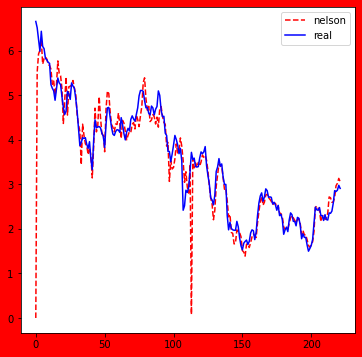

In [ ]:
predict = res_revise.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict.predicted_mean,'r--' , label='nelson')

plt.plot(df_train[:,3],'b' ,label='real')
plt.legend(loc='best')
plt.show()

In [ ]:
mod1 = TVRegressionrho(Yield_test[:,0], B0, B1, B2)#####被説明変数＋説明変数23こいれる
mod2 = TVRegressionrho(Yield_test[:,1], B0, B1, B2)
mod3 = TVRegressionrho(Yield_test[:,2], B0, B1, B2)
mod4 = TVRegressionrho(Yield_test[:,3], B0, B1, B2)

res1 = mod1.fit(maxiter=3000)
res2 = mod2.fit(maxiter=2000)
res3 = mod3.fit(maxiter=2000)
res4 = mod4.fit(maxiter=3000)

#print(res1.summary())

In [ ]:
##これを予測の結果で代替する。（サンプル外の予測に関しては未知数）
##forecastではなく、predictedでやる。

predict1=res1.predict()
predict2=res2.predict()
predict3=res3.predict()
predict4=res4.predict()

r1=Yield_test[222:,0]-predict1[222:]
r2=Yield_test[222:,1]-predict2[222:]
r3=Yield_test[222:,2]-predict3[222:]
r4=Yield_test[222:,3]-predict4[222:]

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()
#rm,r1

(array([0.11552562, 0.26451158, 0.32319932, 0.63852178, 0.21956105,
        0.28312189, 0.16840311, 0.24244068, 0.14283642, 0.09248412,
        0.04673148, 0.19602391, 0.09035574, 0.6002692 , 0.11999809,
        0.08897477, 0.16312088, 0.12021789, 0.01023022, 0.17315628,
        0.98665717]), 5.086341187173091)

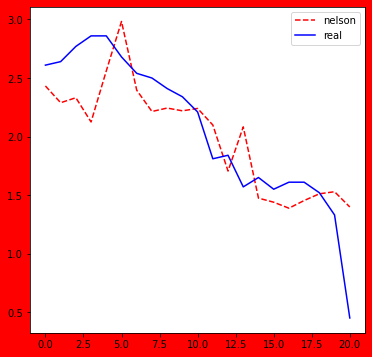

In [ ]:
#nelson-siegelモデルのテスト期間での計測

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(predict1[222:],'r--',label='nelson') ##予測値
plt.plot(Yield_test[222:,0],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

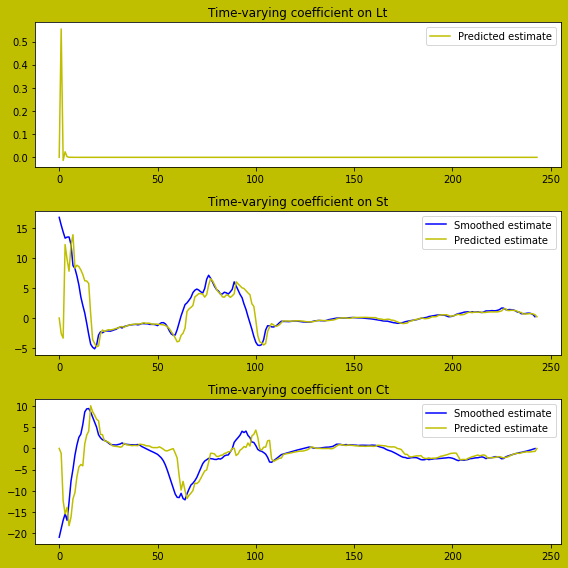

In [ ]:
###係数の推定。(Lt,St,Ctの順番でくる)

fig, axes = plt.subplots(3, figsize=(8, 8),facecolor='y')

ss = pd.DataFrame(res1.smoothed_state.T, columns=['Lt', 'St','Ct'])
sspre=pd.DataFrame(res1.predicted_state.T,columns=['Lt','St','Ct'])

#axes[0].plot(beta_x, label='True')
#axes[0].plot(ss['Lt'], 'b',label='Smoothed estimate')
axes[0].plot(sspre['Lt'], 'y',label='Predicted estimate')
axes[0].set(title='Time-varying coefficient on Lt')
#axes[0].set_ylim([0,3])
axes[0].legend()

#axes[1].plot(beta_w, label='True')
axes[1].plot(ss['St'], 'b',label='Smoothed estimate')
axes[1].plot(sspre['St'], 'y',label='Predicted estimate')
axes[1].set(title='Time-varying coefficient on St')
axes[1].legend()

axes[2].plot(ss['Ct'],'b',label='Smoothed estimate')
axes[2].plot(sspre['Ct'], 'y',label='Predicted estimate')
axes[2].set(title='Time-varying coefficient on Ct')
axes[2].legend()

fig.tight_layout();

In [ ]:
###回帰予測で推定してみる

mod2 = TVRegressionrho(df_train[:,0],Lt_train,St_train,Ct_train)
mod5 = TVRegressionrho(df_train[:,1],Lt_train,St_train,Ct_train)
mod10 = TVRegressionrho(df_train[:,2],Lt_train,St_train,Ct_train)
mod20 = TVRegressionrho(df_train[:,3],Lt_train,St_train,Ct_train)

y2 = mod2.fit(maxtier=5000)
y5 = mod5.fit(maxtier=5000)
y10 = mod10.fit(maxtier=5000)
y20 = mod20.fit(maxtier=10000)

ss2 = y2.smoothed_state.T
ss5 = y5.smoothed_state.T
ss10 = y10.smoothed_state.T
ss20 = y20.smoothed_state.T

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
print(y2.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                TVRegressionrho   Log Likelihood                -316.965
Date:                Sun, 15 Nov 2020   AIC                            651.930
Time:                        10:04:00   BIC                            682.554
Sample:                             0   HQIC                           664.294
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.1695      0.018      9.602      0.000       0.135       0.204
var.St.coeff     0.6559      0.063     10.390      0.000       0.532       0.780
var.Ct.coeff     2.5865      0.403      6.41

In [ ]:
print(y5.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                TVRegressionrho   Log Likelihood                -324.613
Date:                Sun, 15 Nov 2020   AIC                            667.226
Time:                        10:04:00   BIC                            697.850
Sample:                             0   HQIC                           679.590
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.1748      0.020      8.887      0.000       0.136       0.213
var.St.coeff     0.7073      0.069     10.295      0.000       0.573       0.842
var.Ct.coeff     2.8133      0.449      6.26

In [ ]:
print(y10.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                TVRegressionrho   Log Likelihood                 -76.289
Date:                Sun, 15 Nov 2020   AIC                            170.578
Time:                        10:04:00   BIC                            201.202
Sample:                             0   HQIC                           182.942
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0069      0.003      2.309      0.021       0.001       0.013
var.St.coeff     0.0725      0.018      4.071      0.000       0.038       0.107
var.Ct.coeff     1.2928      0.286      4.52

In [ ]:
print(y20.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                TVRegressionrho   Log Likelihood                -190.309
Date:                Sun, 15 Nov 2020   AIC                            398.619
Time:                        10:04:00   BIC                            429.243
Sample:                             0   HQIC                           410.983
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0108      0.008      1.416      0.157      -0.004       0.026
var.St.coeff     0.0210      0.009      2.243      0.025       0.003       0.039
var.Ct.coeff    14.9442      2.374      6.29

In [ ]:
upd_st2,upd_ct2 = make_design_matrix(21,(0.6559,2.5865),(ss2[-1,1],ss2[-1,2]))
lt2 = ss2[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt2
kore = kore[np.newaxis,:,:]

dy2 = {'design': kore}

upd_st5,upd_ct5 = make_design_matrix(21,(0.7073,2.8133),(ss5[-1,1],ss5[-1,2]))
lt5 = ss5[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt5
kore = kore[np.newaxis,:,:]

dy5 = {'design': kore}

upd_st10,upd_ct10 = make_design_matrix(21,(0.0725,1.2928),(ss10[-1,1],ss10[-1,2]))
lt10 = ss10[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt10
kore = kore[np.newaxis,:,:]

dy10 = {'design': kore}

upd_st20,upd_ct20 = make_design_matrix(21,(0.0210,14.9442),(ss20[-1,1],ss20[-1,2]))
lt10 = ss10[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt10
kore = kore[np.newaxis,:,:]

dy20 = {'design': kore}

In [ ]:
forecas2 = y2.get_forecast(steps=21,exog = [Lt_test,St_test,Ct_test],**dy2)
forecas5 = y5.get_forecast(steps=21,exog = [Lt_test,St_test,Ct_test],**dy5)
forecas10 = y10.get_forecast(steps=21,exog = [Lt_test,St_test,Ct_test],**dy10)
forecas20 = y20.get_forecast(steps=21,exog = [Lt_test,St_test,Ct_test],**dy20)

r1=df_test[:,0]-forecas2.predicted_mean
r2=df_test[:,1]-forecas5.predicted_mean
r3=df_test[:,2]-forecas10.predicted_mean
r4=df_test[:,3]-forecas20.predicted_mean

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

(array([4.33705477, 4.13321124, 5.68947441, 3.21129408, 2.38721044,
        2.36746762, 2.32560142, 2.60476311, 3.15357107, 3.12248168,
        2.31201958, 2.9793909 , 3.0507833 , 3.30785406, 3.4006086 ,
        3.42877459, 3.06694602, 3.08569792, 2.63750066, 2.73117915,
        3.40239884]), 66.7352834619198)

#### 2.時変係数（状態方程式の係数推定なし）



In [ ]:
#状態方程式
#係数推定。係数は1個前の値+ノイズのみで決まる。（ノイズの誤差が推定されている。状態変数そのものの誤差にもなるが平均は異なる。）

class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, Lt, St, Ct):
        exog = np.c_[Lt, St, Ct]  # shaped nobs x 3

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=3,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 3 x nobs
        self.ssm['design',0,0,:] = 1
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

        #Which parameters need to be positive?
        self.positive_parameters = slice(0, 3)
        #self.positive_parameters = slice(0, 4)

    @property
    def param_names(self):
        #return ['var.e', 'var.b_0t.coeff', 'var.b_1t.coeff','var.b_2t.coeff']
        return ['var.e', 'var.St.coeff', 'var.Ct.coeff']
        #return ['var.e', 'var.Lt.coeff', 'var.St.coeff', 'var.Ct.coeff']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        #params = np.r_[res.scale, 1, 10, 10]
        #params = np.r_[res.scale, 10, 10]
        params = np.r_[10, 50, 5]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained


    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

#        self['obs_intercept', 0, 0] = params[0]
#        self['obs_cov', 0, 0] = params[1]
#        self['state_cov'] = np.diag(params[2:4])

        self['obs_cov', 0, 0] = params[0]
#        #self['state_cov'] = np.diag(params[1:4])
        self['state_cov',0,0] = 0
        self['state_cov',1,1] = params[1]
        self['state_cov',2,2] = params[2] 

#        self['obs_cov', 0, 0] = params[0]
        
#        self['state_cov',0,0] = params[1]
#        self['state_cov',1,1] = params[2]
#        self['state_cov',2,2] = params[3] 

In [ ]:
mod1 = TVRegression(Yield_test[:,[3]], B0, B1, B2)
res1 = mod1.fit()

print(res1.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  243
Model:                   TVRegression   Log Likelihood                -193.708
Date:                Sun, 15 Nov 2020   AIC                            399.416
Time:                        10:04:00   BIC                            420.374
Sample:                             0   HQIC                           407.857
                                - 243                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0572      0.009      6.282      0.000       0.039       0.075
var.St.coeff     0.0948      0.014      6.646      0.000       0.067       0.123
var.Ct.coeff     0.8025      0.137      5.87

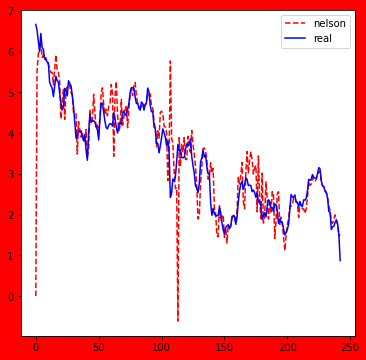

In [ ]:
A1 = res1.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(A1.predicted_mean,'r--',label='nelson') ##予測値
plt.plot(Yield_test[:,3],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

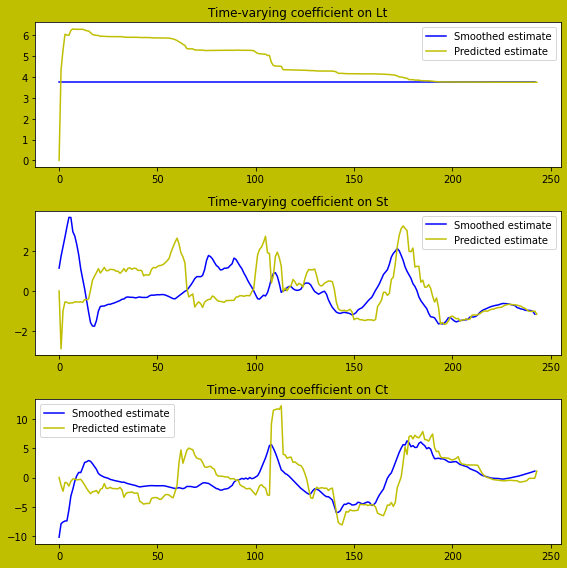

In [ ]:
fig, axes = plt.subplots(3, figsize=(8, 8),facecolor='y')

ss = pd.DataFrame(res1.smoothed_state.T, columns=['Lt', 'St','Ct'])
sspre = pd.DataFrame(res1.predicted_state.T,columns=['Lt','St','Ct'])

#axes[0].plot(beta_x, label='True')
axes[0].plot(ss['Lt'], 'b',label='Smoothed estimate')
axes[0].plot(sspre['Lt'], 'y',label='Predicted estimate')
axes[0].set(title='Time-varying coefficient on Lt')
axes[0].legend()

#axes[1].plot(beta_w, label='True')
axes[1].plot(ss['St'], 'b', label='Smoothed estimate')
axes[1].plot(sspre['St'], 'y', label='Predicted estimate')
axes[1].set(title='Time-varying coefficient on St')
axes[1].legend(loc='best')

axes[2].plot(ss['Ct'],'b',label='Smoothed estimate')
axes[2].plot(sspre['Ct'], 'y',label='Predicted estimate')
axes[2].set(title='Time-varying coefficient on Ct')
axes[2].legend(loc='best')

fig.tight_layout();

In [ ]:
mod1 = TVRegression(Yield_test[:,0], B0, B1, B2)#####被説明変数＋説明変数23こいれる
mod2 = TVRegression(Yield_test[:,1], B0, B1, B2)
mod3 = TVRegression(Yield_test[:,2], B0, B1, B2)
mod4 = TVRegression(Yield_test[:,3], B0, B1, B2)

res1 = mod1.fit(maxiter=2000)
res2 = mod2.fit(maxiter=2000)
res3 = mod3.fit(maxiter=2000)
res4 = mod4.fit(maxiter=2000)

In [ ]:
##これを予測の結果で代替する。（サンプル外の予測に関しては未知数）
##forecastではなく、predictedでやる。

predict1=res1.predict()
predict2=res2.predict()
predict3=res3.predict()
predict4=res4.predict()

r1=Yield_test[222:,0]-predict1[222:]
r2=Yield_test[222:,1]-predict2[222:]
r3=Yield_test[222:,2]-predict3[222:]
r4=Yield_test[222:,3]-predict4[222:]

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()
#rm,r1

(array([0.09868559, 0.0553195 , 0.07700885, 0.14126547, 0.06814578,
        0.02935669, 0.02042077, 0.01658976, 0.01470141, 0.03051257,
        0.05242125, 0.15315521, 0.04295054, 0.19247882, 0.08347729,
        0.21658123, 0.20200956, 0.03986866, 0.00898267, 0.02957883,
        0.84380687]), 2.417317305858634)

In [ ]:
###回帰予測で推定してみる

mod2 = TVRegression(df_train[:,0],Lt_train,St_train,Ct_train)
mod5 = TVRegression(df_train[:,1],Lt_train,St_train,Ct_train)
mod10 = TVRegression(df_train[:,2],Lt_train,St_train,Ct_train)
mod20 = TVRegression(df_train[:,3],Lt_train,St_train,Ct_train)

y2 = mod2.fit(maxtier=3000)
y5 = mod5.fit(maxtier=3000)
y10 = mod10.fit(maxtier=3000)
y20 = mod20.fit(maxtier=3000)

ss2 = y2.smoothed_state.T
ss5 = y5.smoothed_state.T
ss10 = y10.smoothed_state.T
ss20 = y20.smoothed_state.T

In [ ]:
print(y2.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                   TVRegression   Log Likelihood                -264.182
Date:                Sun, 15 Nov 2020   AIC                            540.364
Time:                        10:04:02   BIC                            560.780
Sample:                             0   HQIC                           548.607
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.1289      0.024      5.410      0.000       0.082       0.176
var.St.coeff     0.2392      0.041      5.783      0.000       0.158       0.320
var.Ct.coeff     1.8227      0.334      5.45

In [ ]:
print(y5.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                   TVRegression   Log Likelihood                -251.819
Date:                Sun, 15 Nov 2020   AIC                            515.637
Time:                        10:04:02   BIC                            536.053
Sample:                             0   HQIC                           523.880
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.1124      0.022      5.147      0.000       0.070       0.155
var.St.coeff     0.2150      0.038      5.713      0.000       0.141       0.289
var.Ct.coeff     1.6707      0.307      5.44

In [ ]:
print(y10.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                   TVRegression   Log Likelihood                -209.501
Date:                Sun, 15 Nov 2020   AIC                            431.003
Time:                        10:04:02   BIC                            451.419
Sample:                             0   HQIC                           439.246
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0741      0.014      5.260      0.000       0.046       0.102
var.St.coeff     0.1506      0.024      6.169      0.000       0.103       0.198
var.Ct.coeff     1.1357      0.206      5.50

In [ ]:
print(y20.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                   TVRegression   Log Likelihood                -180.090
Date:                Sun, 15 Nov 2020   AIC                            372.181
Time:                        10:04:02   BIC                            392.597
Sample:                             0   HQIC                           380.424
                                - 222                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
var.e            0.0560      0.010      5.489      0.000       0.036       0.076
var.St.coeff     0.1191      0.019      6.271      0.000       0.082       0.156
var.Ct.coeff     0.8423      0.152      5.52

In [ ]:
#np.random.seed(1234)
#lt = ss2[:,0].mean()#Ltの係数

def make_design_matrix(step,estm_var,first_param):
    st_std = np.random.normal(0,(estm_var[0])**0.5,(step))
    ct_std = np.random.normal(0,(estm_var[1])**0.5,(step))

    li_st = list()
    li_ct = list()
    st_first = first_param[0] + st_std[0]
    ct_first = first_param[1] + st_std[0]
    li_st.append(st_first)
    li_ct.append(ct_first)

    for i in range(1,step):
      st = li_st[i-1] + st_std[i]
      ct = li_ct[i-1] + ct_std[i]
      li_st.append(st)
      li_ct.append(ct)

    st = np.array(li_st)
    ct = np.array(li_ct)

    return st,ct

In [ ]:
upd_st2,upd_ct2 = make_design_matrix(21,(0.2392,1.8288),(ss2[-1,1],ss2[-1,2]))
lt2 = ss2[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt2
kore = kore[np.newaxis,:,:]

dy2 = {'design': kore}

upd_st5,upd_ct5 = make_design_matrix(21,(0.2150,1.6707),(ss5[-1,1],ss5[-1,2]))
lt5 = ss5[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt5
kore = kore[np.newaxis,:,:]

dy5 = {'design': kore}

upd_st10,upd_ct10 = make_design_matrix(21,(0.1506,1.1358),(ss10[-1,1],ss10[-1,2]))
lt10 = ss10[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt10
kore = kore[np.newaxis,:,:]

dy10 = {'design': kore}

upd_st20,upd_ct20 = make_design_matrix(21,(0.1191,0.8423),(ss20[-1,1],ss20[-1,2]))
lt10 = ss10[:,0].mean()
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt10
kore = kore[np.newaxis,:,:]

dy20 = {'design': kore}

In [ ]:
forecas2 = y2.get_forecast(steps=21,**dy2)
forecas5 = y5.get_forecast(steps=21,**dy5)
forecas10 = y10.get_forecast(steps=21,**dy10)
forecas20 = y20.get_forecast(steps=21,**dy20)

r1=df_test[:,0]-forecas2.predicted_mean
r2=df_test[:,1]-forecas5.predicted_mean
r3=df_test[:,2]-forecas10.predicted_mean
r4=df_test[:,3]-forecas20.predicted_mean

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

(array([ 8.57231058,  8.51739976,  9.83150487, 11.24101913, 10.43809488,
        10.03630873, 10.4797775 ,  9.53383433, 10.10603609,  9.57024855,
         8.81587118,  7.68186186,  7.17531742,  7.78975869,  7.50869423,
         7.88298964,  8.77078144,  9.35745956,  9.45559502,  8.42109918,
         7.96655415]), 189.15251676386887)

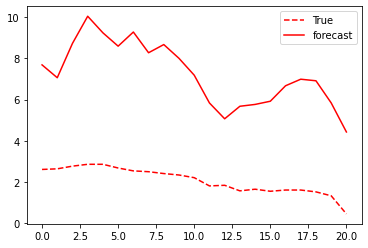

In [ ]:
## 試しに2年債券でやってみる。
upd_st2,upd_ct2 = make_design_matrix(21,(0.1903,1.7365),(ss2[-1,1],ss2[-1,2]))
design_mat = np.c_[np.zeros(21),upd_st2,upd_ct2]
kore = design_mat.T
kore[0,:] = lt2
kore = kore[np.newaxis,:,:]

dy2 = {'design': kore}

forecas = y2.get_forecast(steps=21,**dy2)
ci = forecas.conf_int()

#plt.plot(forecas)
fig = plt.figure(facecolor='w')
plt.plot(df_test[:,0],'r--',label='True')
plt.plot(forecas2.predicted_mean,'r', label='forecast')
#plt.plot(ci[:,0],'b')
#plt.plot(ci[:,1],'y')
plt.legend(loc='best')
plt.show()

#### 3.状態空間（水準・傾き・曲率も推定,design matrixは固定）

In [12]:
starting_values = {'Ct_coeff':2.5,'St_coeff':0.09,'var_e': 5,'var_Lt': B0.std(), 'var_St':B1.std(),'var_Ct':B2.std()}
#starting_values = {'Lt_coeff':1,'Ct_coeff':10,'St_coeff':5,'var_e': 5,'var_Lt': 20, 'var_St':10,'var_Ct':2}
#starting_values = {'var_e': 20,'var_Lt': 100, 'var_St':40,'var_Ct':10}

import collections
from collections import OrderedDict


class YieldModel(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t):

        #exog = np.c_[s_t, np.repeat(1, len(s_t))]  # exog.shape => (nobs, 2)

        super(YieldModel, self).__init__(endog=y_t, k_states=3,initialization='diffuse')

        #self.ssm['design'] = np.ones((self.k_endog, self.k_states, self.nobs))
        self.ssm['design'] = np.ones((self.k_endog,self.k_states))
        self.ssm['design',0,0] = 1

        #These have ok shape. Placeholders since I'm changing them
        #in the update() function
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

        #Dictionary of positions to names
        #self.position_dict = OrderedDict(var_e=1, var_Lt=2,var_St=3, var_Ct=4)
        #self.position_dict  = OrderedDict(Lt_coeff=1,St_coeff=2,Ct_coeff=3,var_e=4,var_Lt=5,var_St=6,var_Ct=7)
        self.position_dict  = OrderedDict(St_coeff=1,Ct_coeff=2,var_e=3,var_Lt=4,var_St=5,var_Ct=6)
        self.initial_values = starting_values
        #self.positive_parameters = slice(0,4)
        #self.positive_parameters = slice(3,7)
        self.positive_parameters = slice(2,6)


    @property
    def param_names(self):
        return list(self.position_dict.keys())

    @property
    def start_params(self):
        """
        Initial values
        """
        #(optional) Use scale for var_e1 and var_e2 starting values
        #params = np.r_[self.initial_values['var_e'],
        #               self.initial_values['var_Lt'],
        #               self.initial_values['var_St'],
        #               self.initial_values['var_Ct']]
        #params = np.r_[self.initial_values['Lt_coeff'],
        #               self.initial_values['St_coeff'],
        #               self.initial_values['Ct_coeff'],
        #               self.initial_values['var_e'],
        #               self.initial_values['var_Lt'],
        #               self.initial_values['var_St'],
        #               self.initial_values['var_Ct']]
        params = np.r_[self.initial_values['St_coeff'],
                       self.initial_values['Ct_coeff'],
                       self.initial_values['var_e'],
                       self.initial_values['var_Lt'],
                       self.initial_values['var_St'],
                       self.initial_values['var_Ct']]
        return params

    def transform_params(self, unconstrained):
        """
        If you need to restrict parameters
        For example, variances should be > 0
        Parameters maybe have to be within -1 and 1
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to reverse what you did in transform_params()
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(YieldModel, self).update(params, **kwargs)

        #The following line is not needed (by default, this matrix is initialized by zeroes),
        #But I leave it here so the dimensions are clearer
        self['design',0,0]=1
        self['design',0,1]=params[0] #1
        self['design',0,2]=params[1] #2

        #self['obs_cov',0,0] = params[0]
        self['obs_cov',0,0] = params[2] #3

        #self['state_cov'] = np.diag(params[1:4])
        self['state_cov'] = np.diag(params[3:6]) #4:7

In [13]:
cus_2 = YieldModel(df_train[:,0])
cus_5 = YieldModel(df_train[:,1])
cus_10 = YieldModel(df_train[:,2])
cus_20 = YieldModel(df_train[:,3])

res_2 = cus_2.fit(maxiter=5000)
res_5 = cus_5.fit(maxtier=5000)
res_10 = cus_10.fit(maxtier=5000)
res_20 = cus_20.fit(maxtier=5000)

print(res_2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  222
Model:                     YieldModel   Log Likelihood                  46.475
Date:                Mon, 23 Nov 2020   AIC                            -74.950
Time:                        12:54:36   BIC                            -44.326
Sample:                             0   HQIC                           -62.586
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
St_coeff      -0.0102     98.253     -0.000      1.000    -192.582     192.561
Ct_coeff   -8.485e-05      0.819     -0.000      1.000      -1.606       1.606
var_e       1.946e-11      0.002   9.87e-09      1.0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2220: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)


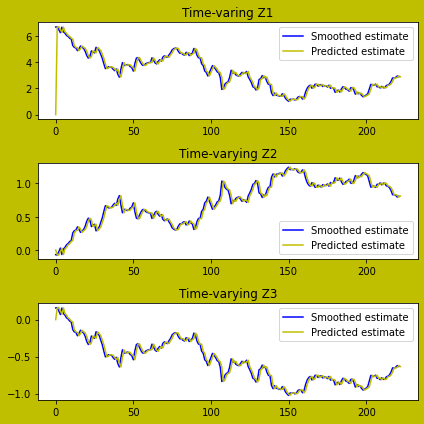

In [14]:
fig, axes = plt.subplots(3, figsize=(6, 6),facecolor='y')

ss = pd.DataFrame(res_10.smoothed_state.T, columns=['Z1', 'Z2','Z3'])
sspre = pd.DataFrame(res_10.predicted_state.T, columns=['Z1', 'Z2','Z3'])

#axes[0].plot(beta_x, label='True')
axes[0].plot(ss['Z1'], 'b', label='Smoothed estimate')
axes[0].plot(sspre['Z1'], 'y',label='Predicted estimate')
axes[0].set(title='Time-varing Z1')
axes[0].legend()

#axes[1].plot(beta_w, label='True')
axes[1].plot(ss['Z2'], 'b',label='Smoothed estimate')
axes[1].plot(sspre['Z2'], 'y',label='Predicted estimate')
axes[1].set(title='Time-varying Z2')
axes[1].legend()

axes[2].plot(ss['Z3'],'b',label='Smoothed estimate')
axes[2].plot(sspre['Z3'], 'y',label='Predicted estimate')
axes[2].set(title='Time-varying Z3')
axes[2].legend()

fig.tight_layout();

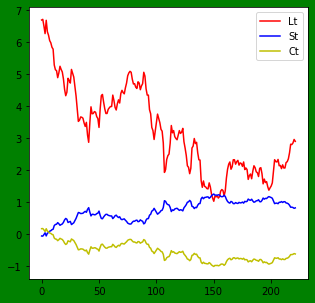

In [17]:
fig = plt.figure(figsize=(5,5),facecolor='g')
plt.plot(ss['Z1'],'r',label='Lt')
plt.plot(ss['Z2'],'b',label='St')
plt.plot(ss['Z3'],'y',label='Ct')
plt.legend(loc='best')
plt.show()

fig.savefig('factor1')

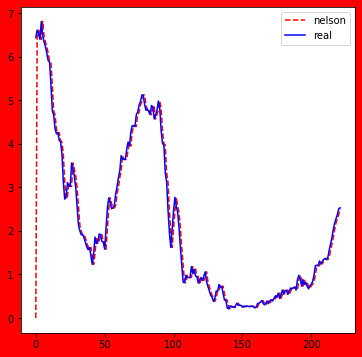

In [ ]:
A1 = res.get_prediction()

fig = plt.figure(figsize=(6,6),facecolor='r')

plt.plot(A1.predicted_mean,'r--',label='nelson') ##予測値
plt.plot(df_train[:,0],'b',label='real') ##実測値
plt.legend(loc='best')
plt.show()

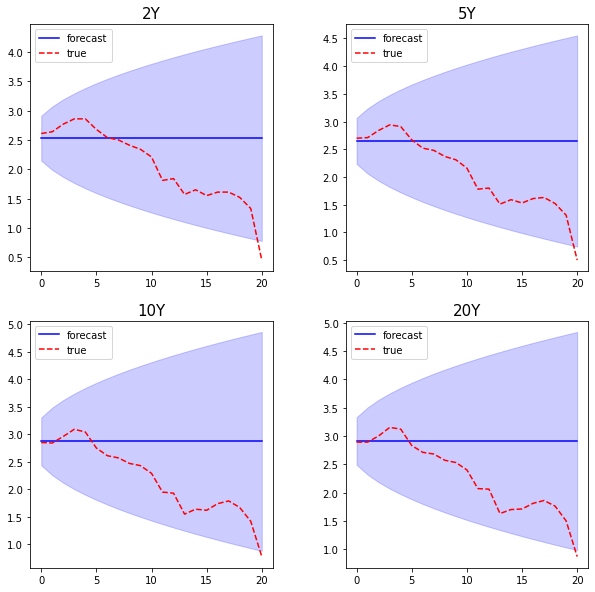

In [ ]:
forecas_y2 = res_2.get_forecast(steps=21)
ci_y2 = forecas_y2.conf_int()
forecas_y5 = res_5.get_forecast(steps=21)
ci_y5 = forecas_y5.conf_int()
forecas_y10 = res_10.get_forecast(steps=21)
ci_y10 = forecas_y10.conf_int()
forecas_y20 = res_20.get_forecast(steps=21)
ci_y20 = forecas_y20.conf_int()

#plt.plot(forecas)
fig = plt.figure(facecolor='w',figsize=(10,10))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
plt.plot(forecas_y2.predicted_mean,'b', label='forecast')
plt.plot(df_test[:,0], 'r--',label='true')
#plt.plot(ci[:,0],'b')
#plt.plot(ci[:,1],'y')
plt.legend(loc='upper left')
plt.title(columns[0],fontsize=15)
plt.fill_between(z,ci_y2[:,0],ci_y2[:,1],color='b',alpha=0.2)

plt.subplot(2,2,2)
plt.plot(forecas_y5.predicted_mean,'b', label='forecast')
plt.plot(df_test[:,1], 'r--',label='true')
#plt.plot(ci[:,0],'b')
#plt.plot(ci[:,1],'y')
plt.legend(loc='upper left')
#plt.ylabel(columns[1])
plt.title(columns[1],fontsize=15)
plt.fill_between(z,ci_y5[:,0],ci_y5[:,1],color='b',alpha=0.2)

plt.subplot(2,2,3)
plt.plot(forecas_y10.predicted_mean,'b', label='forecast')
plt.plot(df_test[:,2], 'r--',label='true')
#plt.plot(ci[:,0],'b')
#plt.plot(ci[:,1],'y')
plt.legend(loc='upper left')
#plt.ylabel(columns[2])
plt.title(columns[2],fontsize=15)
plt.fill_between(z,ci_y10[:,0],ci_y10[:,1],color='b',alpha=0.2)

plt.subplot(2,2,4)
plt.plot(forecas_y20.predicted_mean,'b', label='forecast')
plt.plot(df_test[:,3], 'r--',label='true')
#plt.plot(ci[:,0],'b')
#plt.plot(ci[:,1],'y')
plt.legend(loc='upper left')
#plt.ylabel(columns[3])
plt.title(columns[3],fontsize=15)
plt.fill_between(z,ci_y20[:,0],ci_y20[:,1],color='b',alpha=0.2)

plt.show()

fig.savefig('nelsonsiegel.png')

In [ ]:
r1=df_test[:,0]-forecas_y2.predicted_mean
r2=df_test[:,1]-forecas_y5.predicted_mean
r3=df_test[:,2]-forecas_y10.predicted_mean
r4=df_test[:,3]-forecas_y20.predicted_mean

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

(array([0.04924429, 0.06519202, 0.16575584, 0.27340446, 0.24974987,
        0.10452273, 0.17649363, 0.20778595, 0.30347982, 0.34989284,
        0.48451007, 0.84072885, 0.83736193, 1.18342723, 1.10397011,
        1.14207049, 1.05058317, 1.01927671, 1.12466662, 1.3533477 ,
        2.09037078]), 14.175835139995261)

### PyStanによる状態空間モデル

#### 時変係数の回帰

In [ ]:
import seaborn as sns
import math
#plt.style.use('seaborn-darkgrid')
import sys

from matplotlib.pylab import rcParams
from matplotlib.backends.backend_pdf import PdfPages

#統計ライブラリ
import pystan
#import arviz

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving predict-time-varing-coef.stan to predict-time-varing-coef.stan


In [ ]:
stanmodel = pystan.StanModel(file='predict-time-varing-coef.stan')

ex_train = np.c_[Lt_train,St_train,Ct_train]
exo = np.c_[Lt_test,St_test,Ct_test]
print(exo.T.shape)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_704231a2eba41161497c4b875ad36a84 NOW.


(3, 21)


In [ ]:
data_stan_m2 = dict(T=len(df_train), ex=ex_train.T, y=df_train[:,0], pred_term=len(df_test), ex_test = exo.T)
data_stan_m5 = dict(T=len(df_train), ex=ex_train.T, y=df_train[:,1], pred_term=len(df_test), ex_test = exo.T)
data_stan_m10 = dict(T=len(df_train), ex=ex_train.T, y=df_train[:,2], pred_term=len(df_test), ex_test = exo.T)
data_stan_m20 = dict(T=len(df_train), ex=ex_train.T, y=df_train[:,3], pred_term=len(df_test), ex_test = exo.T)

#fit = stanmodel.sampling(data=data_stan, iter=2000, warmup=500, chains=4, thin=2, seed=1, n_jobs=-1)

fit_m2 = stanmodel.sampling(data=data_stan_m2,seed=6)
fit_m5 = stanmodel.sampling(data=data_stan_m5,seed=6)
fit_m10 = stanmodel.sampling(data=data_stan_m10,seed=6)
fit_m20 = stanmodel.sampling(data=data_stan_m20,seed=6)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
#print(fit)
ms_2 = fit_m2.extract()
ms_5 = fit_m5.extract()
ms_10 = fit_m10.extract()
ms_20 = fit_m20.extract()

#a = ms_2['y_pred'].mean(axis=0)[222:]
#b = ms_5['y_pred'].mean(axis=0)[222:]
#c = ms_10['y_pred'].mean(axis=0)[222:]
#d = ms_20['y_pred'].mean(axis=0)[222:]

a = ms_2['y_pred'].mean(axis=0)[1:]
b = ms_5['y_pred'].mean(axis=0)[1:]
c = ms_10['y_pred'].mean(axis=0)[1:]
d = ms_20['y_pred'].mean(axis=0)[1:]

y_pred = np.c_[a,b,c,d]

In [ ]:
y2_5 = np.array(pd.DataFrame(ms_2['y_pred']).apply(lambda x: np.percentile(x, 5), axis=0))
y2_95 = np.array(pd.DataFrame(ms_2['y_pred']).apply(lambda x: np.percentile(x, 95), axis=0))

y5_5 = np.array(pd.DataFrame(ms_5['y_pred']).apply(lambda x: np.percentile(x, 5), axis=0))
y5_95 = np.array(pd.DataFrame(ms_5['y_pred']).apply(lambda x: np.percentile(x, 95), axis=0))

y10_5 = np.array(pd.DataFrame(ms_10['y_pred']).apply(lambda x: np.percentile(x, 5), axis=0))
y10_95 = np.array(pd.DataFrame(ms_10['y_pred']).apply(lambda x: np.percentile(x, 95), axis=0))

y20_5 = np.array(pd.DataFrame(ms_20['y_pred']).apply(lambda x: np.percentile(x, 5), axis=0))
y20_95 = np.array(pd.DataFrame(ms_20['y_pred']).apply(lambda x: np.percentile(x, 95), axis=0))

y_5 = np.c_[y2_5,y5_5,y10_5,y20_5]
y_95 = np.c_[y2_95,y5_95,y10_95,y20_95]

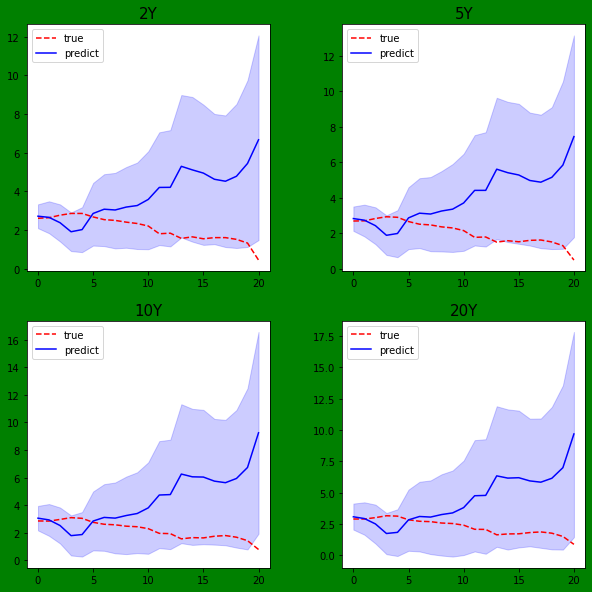

In [ ]:

fig = plt.figure(figsize=(10,10),facecolor='g')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.subplots_adjust(wspace=0.3)

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(z,df_test[:,i],'r--',label='true')#実測値
  plt.plot(z,y_pred[:,i],'b-',label='predict')#予測値
  #plt.fill_between(z,y_5[222:,i], y_95[222:,i], color='blue',alpha=0.2)
  plt.fill_between(z,y_5[1:,i], y_95[1:,i], color='blue',alpha=0.2)
  plt.legend(loc='upper left')
  plt.title(columns[i],fontsize=15)
  #plt.ylabel(columns[i])

fig.savefig('statespaces_timevaring_a.png')

In [ ]:
r1=df_test[:,0]-y_pred[:,0]
r2=df_test[:,1]-y_pred[:,1]
r3=df_test[:,2]-y_pred[:,2]
r4=df_test[:,3]-y_pred[:,3]

rm = np.concatenate([r1.reshape(-1,1),r2.reshape(-1,1),r3.reshape(-1,1),r4.reshape(-1,1)],axis=1)
#print(rm.shape)
RM = rm*rm
SE=np.sum(RM,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

(array([0.1596676 , 0.05139223, 0.43549359, 1.1930147 , 1.07123576,
        0.14366209, 0.51681339, 0.50860002, 0.78443158, 0.95125776,
        1.46224227, 2.6283657 , 2.64160654, 4.33006809, 4.06135617,
        4.03734024, 3.65545199, 3.52020831, 3.9143897 , 4.89464683,
        7.6861503 ]), 48.64739485063203)

In [ ]:
#with open('output/fit-summary.txt', 'w') as f:
#    f.write(str(fit_m2))

#rcParams['figure.figsize'] = 40, 40

palette = sns.color_palette()
ms = fit_m10.extract(permuted=False, inc_warmup=True)
iter_from = fit_m10.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_m10.sim['fnames_oi']
#num_pages = math.ceil(len(paraname)/4)
num_pages = math.ceil(len(paraname)/20)

#with PdfPages('y_10.pdf') as pdf:
#    for pg in range(num_pages):
#        plt.figure()
#        for pos in range(4):
#            pi = pg*4 + pos
#            if pi >= len(paraname): break
#            plt.subplot(4, 2, 2*pos+1)
#            plt.tight_layout()
#            [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
#            plt.title(paraname[pi])
#            plt.subplot(4, 2, 2*(pos+1))
#            plt.tight_layout()
#            [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
#            plt.title(paraname[pi])
#        pdf.savefig()
#        plt.close()

In [ ]:
len(paraname)
num_pages

26

In [ ]:
palette = sns.color_palette()
ms = fit_m20.extract(permuted=False, inc_warmup=True)
iter_from = fit_m20.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_m20.sim['fnames_oi']
#num_pages = math.ceil(len(paraname)/4)
num_pages = math.ceil(len(paraname)/20)


rcParams['figure.figsize'] = 30, 30

with PdfPages('y_20.pdf') as pdf:
    for pg in range(num_pages):
        plt.figure()
        for pos in range(20):
            pi = pg*20 + pos
            if pi >= len(paraname): break
            plt.subplot(20, 2, 2*pos+1)
            plt.tight_layout()
            [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
            plt.title(paraname[pi])
            plt.subplot(20, 2, 2*(pos+1))
            plt.tight_layout()
            [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
            plt.title(paraname[pi])
        pdf.savefig()
        plt.close()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [ ]:
#rcParams['figure.figsize'] = 40, 40
#fit_m2.plot()
#ms_20.plot()
#plt.show()

In [ ]:
y_pred.shape
#y_pred[15:]

(21, 4)

In [ ]:
X.shape
z = np.array(range(21)).reshape(-1)
z.shape

In [ ]:
ms_2 = fit_m2.extract()
y = ms_2['y_pred'].mean(axis=0)[222:]
y_5 = np.array(pd.DataFrame(ms_2['y_pred']).apply(lambda x: np.percentile(x, 5), axis=0))
y_95 = np.array(pd.DataFrame(ms_2['y_pred']).apply(lambda x: np.percentile(x, 95), axis=0))

fig = plt.figure(figsize=(6,6),facecolor='r')
plt.plot(z, df_test[:,1], label='observed')
plt.plot(z, y, label='predicted', c='red')
plt.fill_between(z,y_5[222:], y_95[222:], color='red',alpha=0.2)
plt.legend(loc='best')
plt.show()

#### 通常の状態空間

In [ ]:
#from google.colab import files
#uploaded = files.upload()

Saving yield-only.stan to yield-only.stan


In [ ]:
#stanmodel_y = pystan.StanModel(file='yield-only.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc8b574185d9b6ce1e21f25950c1a88a NOW.


In [ ]:
#data_stan_y2 = dict(T=len(df_train), y=df_train[:,0], pred_term=len(df_test))
#data_stan_y5 = dict(T=len(df_train), y=df_train[:,1], pred_term=len(df_test))
#data_stan_y10 = dict(T=len(df_train),y=df_train[:,2], pred_term=len(df_test))
#data_stan_y20 = dict(T=len(df_train), y=df_train[:,3], pred_term=len(df_test))

In [ ]:
#fit_y2 = stanmodel_y.sampling(data=data_stan_y2,seed=5,iter=5000,thin=2)
#fit_y5 = stanmodel_y.sampling(data=data_stan_y5,seed=5)
#fit_y10 = stanmodel_y.sampling(data=data_stan_y10,seed=5)
#fit_y20 = stanmodel_y.sampling(data=data_stan_y20,seed=5)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
#print(fit)
#ys_2 = fit_y2.extract()
#ys_5 = fit_y5.extract()
#ys_10 = fit_y10.extract()
#ys_20 = fit_y20.extract()

#a = ys_2['y_pred'].mean(axis=0)[222:]
#b = ys_5['y_pred'].mean(axis=0)[222:]
#c = ys_10['y_pred'].mean(axis=0)[222:]
#d = ys_20['y_pred'].mean(axis=0)[222:]

#y_pred_o = np.c_[a,b,c,d]

In [ ]:
#fig = plt.figure(figsize=(6,6),facecolor='g')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
#for i in range(4):
#  plt.subplot(4,1,i+1)
#  plt.plot(df_test[:,i],'r--',label='true')#実測値
#  plt.plot(y_pred_o[:,i],'b-',label='predict')#予測値
#  plt.ylabel(columns[i])

#fig.savefig('statespaces1.png')

In [ ]:
#ry1=df_test[:,0]-y_pred_o[:,0]
#ry2=df_test[:,1]-y_pred_o[:,1]
#ry3=df_test[:,2]-y_pred_o[:,2]
#ry4=df_test[:,3]-y_pred_o[:,3]

#rym = np.concatenate([ry1.reshape(-1,1),ry2.reshape(-1,1),ry3.reshape(-1,1),ry4.reshape(-1,1)],axis=1)
#print(rm.shape)
#RYM = rym*rym
#SE_y=np.sum(RYM,axis=1)
#MSE_y=SE_y / 4.0
#RMSE_y=np.sqrt(MSE_y)
#RMSE_y,RMSE_y.sum()

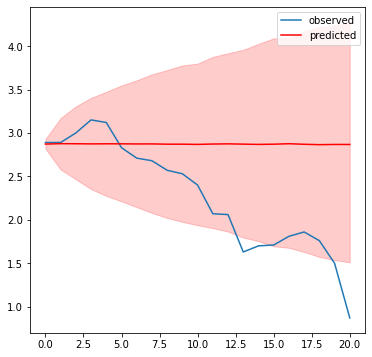

In [ ]:
#ys_2 = fit_y2.extract()
#yo = ys_2['y_pred'].mean(axis=0)[222:]
#yo_5 = np.array(pd.DataFrame(ys_10['y_pred']).apply(lambda x: np.percentile(x, 5), axis=0))
#yo_95 = np.array(pd.DataFrame(ys_10['y_pred']).apply(lambda x: np.percentile(x, 95), axis=0))

#z = np.array(range(21)).reshape(-1)
#fig = plt.figure(figsize=(6,6),facecolor='w')
#plt.plot(z, df_test[:,3], label='observed')
#plt.plot(z, c, label='predicted', c='red')
#plt.fill_between(z,yo_5[222:], yo_95[222:], color='red',alpha=0.2)
#plt.legend(loc='best')
#plt.show()